## ScanContext++ implementation

In [8]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from scipy import stats
from scipy import spatial
from scipy.linalg import circulant
from dataclasses import dataclass

def points_to_polar_context(pnts, sc_shape, max_length):
    bins_theta, bins_distances = np.linspace(0, 360, sc_shape[1]+1), np.linspace(0, max_length, sc_shape[0]+1)

    thetas = np.rad2deg(np.arctan2(pnts[:, 1], pnts[:, 0])) % 360
    distances = np.linalg.norm(pnts[:, 0:2], axis=1)
    
    result = stats.binned_statistic_2d(distances, thetas, pnts[:, 2], 'max', bins=[bins_distances, bins_theta])
    result.statistic[np.isnan(result.statistic)] = 0.0
    return result.statistic

def points_to_cart_context(pnts, sc_shape, max_length):
    binsx, binsy = np.linspace(-max_length/2, max_length/2, sc_shape[0]+1), np.linspace(-max_length/2, max_length/2, sc_shape[1]+1)
    result = stats.binned_statistic_2d(pnts[:, 0], pnts[:, 1], pnts[:, 2], 'max', bins=[binsx, binsy])
    result.statistic[np.isnan(result.statistic)] = 0.0
    return result.statistic


def context_to_retrieval_key(context, axis=1, ord=1):
    return np.linalg.norm(context, axis=axis, ord=ord)

def context_to_aligning_key(context, axis=0, ord=1):
    return np.linalg.norm(context, axis=axis, ord=ord)

def context_distance(context1, context2):
    nom = np.sum(context1 * context2, axis = 0)
    denom = np.linalg.norm(context1, axis = 0) * np.linalg.norm(context2, axis = 0)
    if np.sum(denom == 0.0) == context1.shape[1]:
        return 1.0
    else:
        nom[nom == 0.0] = 1e-30
        denom[denom==0.0] = 1e-30
        cos_sim = np.true_divide(nom, denom)
        n_columns = context1.shape[1]
        return 1.0 - np.sum(cos_sim) / n_columns
    
def augmented_cart_context(points, shape, max_len):
    context1 = points_to_cart_context(points, shape, max_len)
    context2 = context1[::-1, ::-1]
    return [context1, context2]

def augmented_polar_context(points, shape, max_len):
    context1 = points_to_polar_context(points, shape, max_len)
    context2 = points_to_polar_context(points + np.array([0., 2., 0.]), shape, max_len)
    context3 = points_to_polar_context(points - np.array([0., 2., 0.]), shape, max_len)
    return [context1, context2, context3]

class ContextManager:
    @dataclass(frozen=True)
    class Params:
        num_bins_horizontal: int = 100
        num_bins_vertical: int = 100
        max_length: float = 100.0
        type: str = "polar"
        n_last_frames_to_skip: int = 25
        threshold_to_detect_loop: float = 0.1

    def __init__(self, params = Params()):
        assert params.type == "polar" or params.type == "cart"
        self.params = params
        self.points = {}
        self.keys = []
        self.contexts = []
        self.retrieval_keys = []
        self.current_context = None
        self.current_retrieval_key = None
        if self.params.type == "cart":
            self.augmented_context_len = 2
            self.gen_context_with_augmentation = augmented_cart_context
        elif self.params.type == "polar":
            self.augmented_context_len = 3
            self.gen_context_with_augmentation = augmented_polar_context
        self.shape = (self.params.num_bins_horizontal, self.params.num_bins_vertical)
        
    def add_points(self, key, points):
        contexts = self.gen_context_with_augmentation(points, self.shape, self.params.max_length)
        retrieval_keys = [context_to_retrieval_key(c) for c in contexts]
        
        self.points[key] = points
        self.keys.extend([key] * self.augmented_context_len)
        self.contexts.extend(contexts)
        self.retrieval_keys.extend(retrieval_keys)
        
        self.current_context = self.contexts[-self.augmented_context_len]
        self.current_retrieval_key = self.retrieval_keys[-self.augmented_context_len]
        
    def _build_trees(self):
        retrieval_tree = spatial.KDTree(self.retrieval_keys[:-self.augmented_context_len * (self.params.n_last_frames_to_skip + 1)])
        aligning_key = context_to_aligning_key(self.current_context)
        aligning_permutations = circulant(aligning_key).T
        aligning_tree = spatial.KDTree(aligning_permutations)
        
        return retrieval_tree, aligning_tree
    
    def _get_initial_align(self, best_cand_idx, best_cand_align_key):
        if self.params.type == 'cart':
            approx_rotation = 180.0 if best_cand_idx % self.augmented_context_len == 1 else 0
            approx_translation = self.params.num_bins_vertical - best_cand_align_key if best_cand_align_key > self.params.num_bins_vertical // 2 else -best_cand_align_key
            approx_translation *= self.params.max_length / self.params.num_bins_vertical
        elif self.params.type == "polar":
            approx_rotation = best_cand_align_key * (360 / self.params.num_bins_vertical)
            approx_translation = -[0, 2, -2][best_cand_idx % self.augmented_context_len]
        return approx_rotation, approx_translation
        
    def find_candidate(self):
        if len(self.keys) <= (self.params.n_last_frames_to_skip + 1) * self.augmented_context_len:
            return None, None, None, None
        
        ret_tree, align_tree = self._build_trees()
        _, candidates_idxs = ret_tree.query(self.current_retrieval_key, k=[1])
            
        best_cand_idx, min_context_dist = None, 1.0
        best_cand_align_key = 0
        for i in candidates_idxs:
            candidate_context = self.contexts[i]
            candidate_aligning_key = context_to_aligning_key(candidate_context)
            
            _, aligning_idx = align_tree.query(candidate_aligning_key, k=1)
            distance = context_distance(np.roll(self.current_context, aligning_idx, axis = 1), candidate_context)
            
            if distance < min_context_dist:
                best_cand_idx, min_context_dist, best_cand_align_key = i, distance, aligning_idx
                
        if min_context_dist <= self.params.threshold_to_detect_loop:
            approx_rotation, approx_translation = self._get_initial_align(best_cand_idx, best_cand_align_key)
            return self.keys[best_cand_idx], min_context_dist, approx_translation, approx_rotation
        else:
            return None, None, None, None

In [36]:
np.random.seed(256)

params = ContextManager.Params(100, 100, 100.0, type="cart", n_last_frames_to_skip=0, threshold_to_detect_loop = 0.9)
cm1 = ContextManager(params)
params = ContextManager.Params(100, 100, 100.0, type="polar", n_last_frames_to_skip=0, threshold_to_detect_loop = 0.9)
cm2 = ContextManager(params)

for i in range(0, 20):
    meanx, meany = np.random.uniform(-50, 50, size = 2)
    covx, covy = np.random.uniform(9, 49, size = 2)
    cross_cov = np.random.uniform(-np.min([covx, covy, 9]), np.min([covx, covy, 9]))
    
    points = np.random.multivariate_normal([meanx, meany], [[covx, cross_cov], [cross_cov, covy]], size = (5000))
    points = np.hstack((points, np.ones((len(points), 1))))
    
    points = np.vstack((points, np.hstack((np.random.uniform(-100, 100, size = (2000, 2)), np.ones((2000, 1))))))
    cm1.add_points(i, points)
    cm2.add_points(i, points)
    
    if i == 12:
        query_points = np.copy(points)
        query_points_rotated = np.copy(points)
        np.random.shuffle(query_points_rotated)
        a = np.deg2rad(180)
        query_points_rotated[:, 0:2] = (np.array([[np.cos(a), -np.sin(a)], [np.sin(a), np.cos(a)]]) @ points[:, 0:2].T).T
        query_points_rotated[:, 0:2] += np.array([0.0, 10.0])
        # query_points_rotated = np.vstack((query_points_rotated, np.hstack((np.random.uniform(-100, 100, size = (2000, 2)), np.ones((2000, 1))))))
        
cm1.add_points(20, query_points_rotated)
cm2.add_points(20, query_points_rotated)

res1 = cm1.find_candidate()
res2 = cm2.find_candidate()
print(res1, res2)

(12, 0.08427625143653927, 10.0, 180.0) (16, 0.7686392397344421, 2, 169.20000000000002)


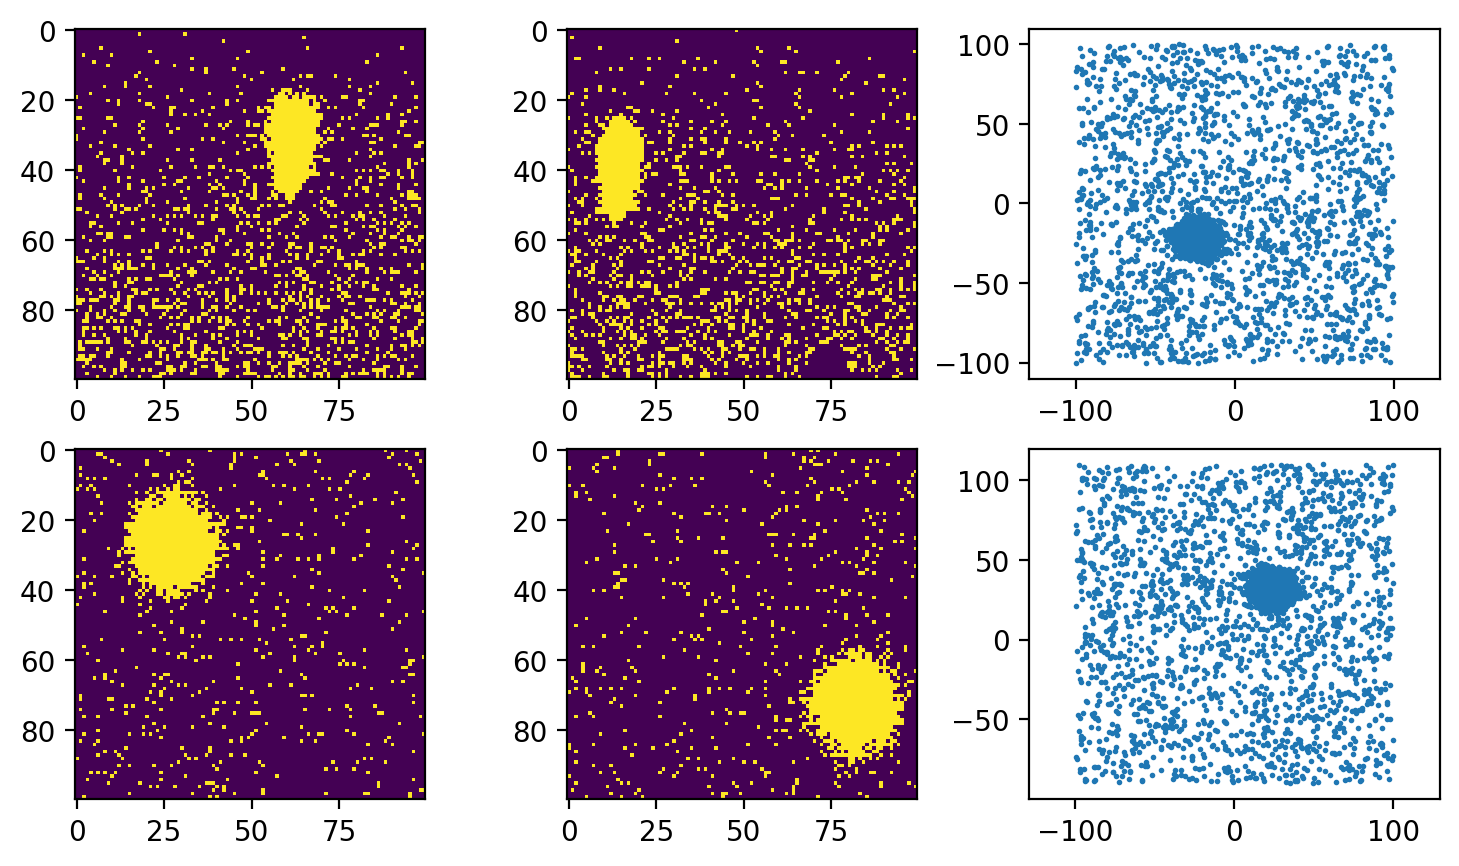

In [34]:
pc1 = points_to_polar_context(query_points, [100, 100], 100.0)
pc2 = points_to_polar_context(query_points_rotated, [100, 100], 100.0)

rk1 = context_to_retrieval_key(pc1)
rk2 = context_to_retrieval_key(pc2)
# print(np.sum(rk1 == rk2), context_distance(pc1, pc2))

fig, ax = plt.subplot_mosaic("ABC;DEF", figsize = (9, 5))
ax['A'].imshow(pc1)
ax['B'].imshow(pc2)
ax['C'].scatter(query_points[:, 0], query_points[:, 1], s=1)
ax['C'].axis("equal")

cc1 = points_to_cart_context(query_points, [100, 100], 100.0)
cc2 = points_to_cart_context(query_points_rotated, [100, 100], 100.0)
rk1 = context_to_retrieval_key(cc1)
rk2 = context_to_retrieval_key(cc2)
# print(np.sum(rk1 == rk2), context_distance(cc1, cc2))

ax['D'].imshow(cc1)
ax['E'].imshow(cc2)
ax['F'].scatter(query_points_rotated[:, 0], query_points_rotated[:, 1], s=1)
ax['F'].axis("equal")
plt.show()